In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm

In [81]:
data_dir = '/Users/mikalalowrance/repos/STA380/data/EuroSAT_RGB'

# Transform and normalize the images
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),          
    transforms.Normalize((0.5), (0.5))])

# Load images
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training and test sets (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

# Load the data into DataLoader objects
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


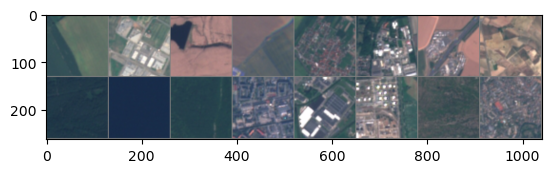

In [83]:
# Display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16]))

In [95]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [84]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 11)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=11, bias=True)
)


In [85]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=11, bias=True)
)

In [91]:
# Define loss function & optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

testiter = iter(test_loader)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print('Finished Training')

Epoch 1, Loss: 41.82559439980772
Epoch 2, Loss: 31.443324520743104
Epoch 3, Loss: 24.42481943277212
Epoch 4, Loss: 17.885533263697425
Epoch 5, Loss: 13.1263707784506
Epoch 6, Loss: 8.642154778249164
Epoch 7, Loss: 7.209682154232229
Epoch 8, Loss: 6.137772229472561
Epoch 9, Loss: 4.055909472016188
Epoch 10, Loss: 3.5601762889625403
Finished Training


In [92]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 86.57%


In [ ]:
#Test accuracy is very low likely because of not using gradient calculation in an effort to speed up computation time

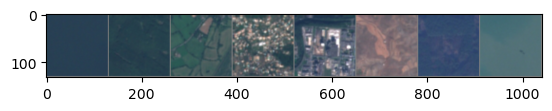

GroundTruth: SeaLake Forest Pasture Residential Industrial HerbaceousVegetation Forest SeaLake


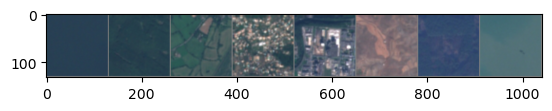

Predicted: SeaLake Forest Pasture Residential Industrial AnnualCrop Forest SeaLake


In [109]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Selecting the first 8 images for the 8x2 grid
images = images[:8]
labels = labels[:8]

# Show the first row of ground truth images
imshow(torchvision.utils.make_grid(images, nrow=8))
print('GroundTruth:', ' '.join(f'{dataset.classes[labels[j]]}' for j in range(8)))

# Get predictions for the first 8 images
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show the second row of predicted images
imshow(torchvision.utils.make_grid(images, nrow=8))
print('Predicted:', ' '.join(f'{dataset.classes[predicted[j]]}' for j in range(8)))


Model commonly, inaccurately predicts the "Herbaceous Vegetation" as "Annual Crop".

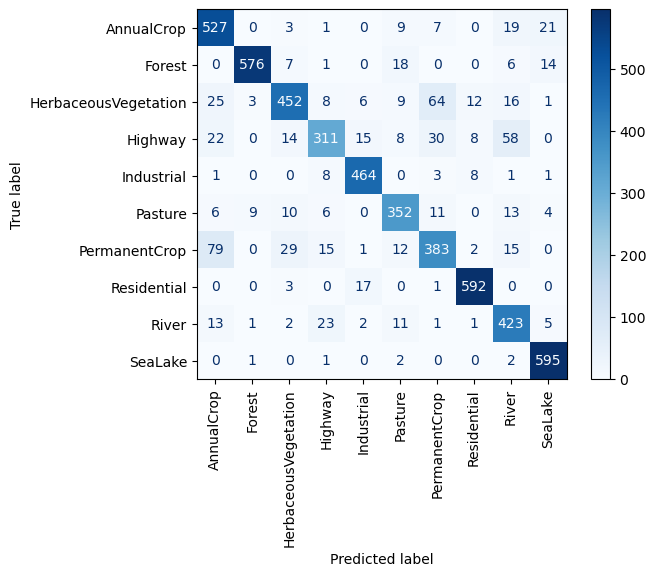

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()